# Part 1

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_coalition_results(base_save_dir, dataset_name, approach_name):
    def find_cc_folders(base_dir):
        cc_dirs = []
        for name in os.listdir(base_dir):
            if name.startswith("CC_"):
                cc_val = float(name.replace("CC_", ""))
                full_path = os.path.join(base_dir, name)
                cc_dirs.append((cc_val, full_path))
        cc_dirs.sort(key=lambda x: x[0])
        return cc_dirs

    cc_folders = find_cc_folders(base_save_dir)
    all_counts = []

    for cc_val, cc_dir in cc_folders:
        for fname in os.listdir(cc_dir):
            if fname.startswith("Nash_Counts_") and fname.endswith(".csv"):
                path = os.path.join(cc_dir, fname)
                df = pd.read_csv(path)

                if "Complete_Occurrences" in df.columns and "Static_Occurrences" not in df.columns:
                    df["Static_Occurrences"] = df["Complete_Occurrences"]

                df["comm_cost"] = cc_val
                df["source_file"] = fname
                df["n_trials"] = 100
                df["nash_rate"] = df["Static_Occurrences"] / df["n_trials"]
                df["lottery_rate"] = df["Lottery_Occurrences"] / df["n_trials"]
                all_counts.append(df)

    counts_df = pd.concat(all_counts, ignore_index=True)

    x_values = list(range(10, 101, 10))
    cc_groups = {}
    for cc_val, subdf in counts_df.groupby("comm_cost"):
        sdf = subdf.sort_values("n_clients")
        static_g = sdf[["n_clients", "Static_Occurrences"]].reset_index(drop=True)
        lot_g = sdf[["n_clients", "Lottery_Occurrences"]].reset_index(drop=True)
        static_g = static_g.set_index("n_clients").reindex(x_values).reset_index()
        lot_g = lot_g.set_index("n_clients").reindex(x_values).reset_index()
        cc_groups[cc_val] = (static_g, lot_g)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    ax1, ax2 = axes

    for cc_val, (static_g, _) in cc_groups.items():
        ax1.plot(static_g["n_clients"], static_g["Static_Occurrences"], marker="o", label=f"CC={cc_val}")

    ax1.set_title(f"Complete Information {dataset_name} - {approach_name}")
    ax1.set_xlabel("Number of clients")
    ax1.set_ylabel("Grand coalition occurrences (per 100 trials)")
    ax1.set_xticks(x_values)
    ax1.set_ylim(-1, 103)
    ax1.grid(True, linestyle="--", alpha=0.7)
    ax1.legend()

    for cc_val, (_, lot_g) in cc_groups.items():
        ax2.plot(lot_g["n_clients"], lot_g["Lottery_Occurrences"], marker="o", label=f"CC={cc_val}")

    ax2.set_title(f"Lottery Scenario {dataset_name} - {approach_name}")
    ax2.set_xlabel("Number of clients")
    ax2.set_ylabel("Grand coalition occurrences (per 100 trials)")
    ax2.set_xticks(x_values)
    ax2.set_ylim(-1, 103)
    ax2.grid(True, linestyle="--", alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.15)

    figs_dir = os.path.join("figs")
    os.makedirs(figs_dir, exist_ok=True)
    filename = f"{dataset_name.lower()}_{approach_name.lower()}.pdf"
    save_path = os.path.join(figs_dir, filename)
    fig.savefig(save_path, bbox_inches="tight")
    plt.draw()
    #plt.close(fig)

### FedLR Spambase

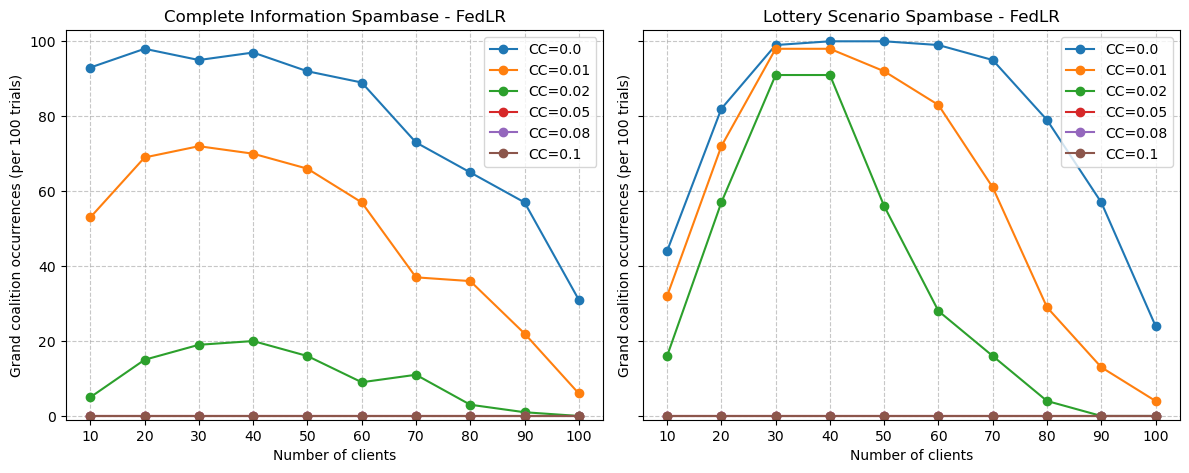

In [7]:
plot_coalition_results(
    base_save_dir="../results/spambase_fedlr_tree_comcost",
    dataset_name="Spambase",
    approach_name="FedLR"
)

### FedFor Spambase

In [ ]:
plot_coalition_results(
    base_save_dir="../results/spambase_fedfor_linear_comcost",
    dataset_name="Spambase",
    approach_name="FedFor"
)


### FedLR HuGaDB

In [ ]:
plot_coalition_results(
    base_save_dir="../results/hugadb_fedlr_rf_comcost",
    dataset_name="HuGaDB",
    approach_name="FedLR"
)


### FedFor HuGaDB

In [ ]:
plot_coalition_results(
    base_save_dir="../results/hugadb_fedfor_linear_comcost",
    dataset_name="HuGaDB",
    approach_name="FedFor"
)


### FedLR Adult

In [ ]:
plot_coalition_results(
    base_save_dir="../results/adult_fedlr_linear_comcost",
    dataset_name="Adult",
    approach_name="FedLR"
)

### FedFor Adult

In [ ]:
plot_coalition_results(
    base_save_dir="../results/adult_fedfor_linear_comcost",
    dataset_name="Adult",
    approach_name="FedFor"
)

### FedLR KDD

In [ ]:
plot_coalition_results(
    base_save_dir="../results/kdd_fedlr_rf_comcost",
    dataset_name="KDD",
    approach_name="FedLR"
)

### FedFor KDD

In [ ]:
plot_coalition_results(
    base_save_dir="../results/kdd_fedfor_tree_comcost",
    dataset_name="KDD",
    approach_name="FedFor"
)

# Part 2

In [ ]:
import numpy as np
import glob
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def plot_global_vs_best_accuracy(
    dataset_name,
    approach_name,
    dataset_name_,
    approach_name_,
    base_dir
):
    
    figs_dir = os.path.join("figs")
    summary_dir = os.path.join("summary")

    os.makedirs(figs_dir, exist_ok=True)
    os.makedirs(summary_dir, exist_ok=True)

    out_csv = os.path.join(summary_dir, f"{dataset_name}_{approach_name}_all.csv")
    out_pdf = os.path.join(figs_dir, f"{dataset_name}_{approach_name}_plots.pdf")


    csv_paths = glob.glob(os.path.join(base_dir, "CC_*/best_client_vs_predicted_global.csv"))

    all_dfs = []
    for path in csv_paths:
        df = pd.read_csv(path)
        df = df.rename(columns={
            "n_clients": "n_clients",
            "predicted_global": "predicted_global",
            "actual_global": "actual_global",
            "best_client_acc": "best_client_acc"
        })
        df["pred_minus_best"] = df["predicted_global"] - df["best_client_acc"]
        df["actual_minus_best"] = df["actual_global"] - df["best_client_acc"]
        all_dfs.append(df)

    df_all = pd.concat(all_dfs, ignore_index=True)

    agg = (
        df_all.groupby("n_clients")
            .agg(
                max_pred_minus_best=("pred_minus_best", "max"),
                max_actual_minus_best=("actual_minus_best", "max"),
                avg_pred_minus_best=("pred_minus_best", "mean"),
                avg_actual_minus_best=("actual_minus_best", "mean"),
                std_pred_minus_best=("pred_minus_best", "std"),
                std_actual_minus_best=("actual_minus_best", "std"),
                count=("pred_minus_best", "size")
            )
            .reset_index()
            .sort_values("n_clients")
    )

    agg.to_csv(out_csv, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    y_all = np.r_[
        agg["max_actual_minus_best"].values,
        agg["avg_actual_minus_best"].values,
        agg["max_pred_minus_best"].values,
        agg["avg_pred_minus_best"].values,
    ]
    ymin, ymax = np.min(y_all), np.max(y_all)
    rng = ymax - ymin if ymax > ymin else 0.001
    pad = max(0.001, 0.05 * rng)
    ylow, yhigh = ymin - pad, ymax + pad

    raw_step = rng / 8.0
    step = max(0.001, round(raw_step, 3))
    minor_step = step / 2.0

    ax = axes[0]
    ax.plot(agg["n_clients"], agg["max_actual_minus_best"], marker="o", label="Max actual - best client")
    ax.plot(agg["n_clients"], agg["avg_actual_minus_best"], marker="o", linestyle="--", label="Avg actual - best client")
    ax.set_title(f"{dataset_name_} {approach_name_}")
    ax.set_xlabel("Number of clients")
    ax.set_ylabel("Difference global accuracy and best client accuracy")
    ax.set_xlim(7, 102)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.margins(x=0.05)
    ax.set_ylim(ylow, yhigh)
    ax.yaxis.set_major_locator(MultipleLocator(step))
    ax.yaxis.set_minor_locator(MultipleLocator(minor_step))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.grid(True, which="both", axis="both", alpha=0.35)
    ax.legend()

    ax = axes[1]
    ax.plot(agg["n_clients"], agg["max_pred_minus_best"], marker="s", label="Max predicted - best client")
    ax.plot(agg["n_clients"], agg["avg_pred_minus_best"], marker="s", linestyle="--", label="Avg predicted - best client")
    ax.set_title(f"{dataset_name_} {approach_name_}")
    ax.set_xlabel("Number of clients")
    ax.set_xlim(7, 102)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.margins(x=0.05)
    ax.set_ylim(ylow, yhigh)
    ax.yaxis.set_major_locator(MultipleLocator(step))
    ax.yaxis.set_minor_locator(MultipleLocator(minor_step))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.grid(True, which="both", axis="both", alpha=0.35)
    ax.legend()

    plt.tight_layout()
    plt.savefig(out_pdf, format="pdf", bbox_inches="tight")
    plt.close(fig)

### FedLR Spambase

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="spambase",
    approach_name="fedlr",
    dataset_name_="Spambase",
    approach_name_="FedLR",
    base_dir="../results/spambase_fedlr_tree_commcost"
)

### FedFor Spambase

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="spambase",
    approach_name="fedfor",
    dataset_name_="Spambase",
    approach_name_="FedFor",
    base_dir="../results/spambase_fedfor_linear_commcost"
)

### FedLR HuGaDB

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="huagadb",
    approach_name="fedlr",
    dataset_name_="HuGaDB",
    approach_name_="FedLR",
    base_dir="../results/hugadb_fedlr_rf_commcost"
)

### FedFor HuGaDB

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="hugadb",
    approach_name="fedfor",
    dataset_name_="HuGaDB",
    approach_name_="FedFor",
    base_dir="../results/hugadb_fedfor_linear_commcost"
)

### FedLR Adult

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="adult",
    approach_name="fedlr",
    dataset_name_="Adult",
    approach_name_="FedLR",
    base_dir="../results/adult_fedlr_linear_comcost"
)

### FedFor Adult

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="adult",
    approach_name="fedfor",
    dataset_name_="Adult",
    approach_name_="FedFor",
    base_dir="../results/adult_fedfor_linear_comcost"
)

### FedLR KDD

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="kdd",
    approach_name="fedlr",
    dataset_name_="KDD",
    approach_name_="FedLR",
    base_dir="../results/kdd_fedlr_rf_comcost"
)

### FedFor KDD

In [ ]:
plot_global_vs_best_accuracy(
    dataset_name="kdd",
    approach_name="fedfor",
    dataset_name_="KDD",
    approach_name_="FedFor",
    base_dir="../results/kdd_fedfor_tree_comcost"
)